# JUPYTER NOTEBOOK FOR HOMEWORK 3
Using classifiers to identify very noisy images of faces with happy or sad expressions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
#from helper import getBinaryfer13Data, sigmoid, sigmoid_cost, error_rate
from helper import y2indicator, getBinaryfer13Data, sigmoid, sigmoid_cost, error_rate, init_weight_and_bias, \
                    init_weight_and_bias_NN, ReLU, softmax

# PART 1 - Logistic regressor

In [2]:
def BGD(theta, alpha, num_iters, h, X, y, n):
    theta_history = np.ones((num_iters,n+1))
    cost = np.ones(num_iters)
    for i in range(0,num_iters):
        theta[0] = theta[0] - (alpha/X.shape[0]) * sum(h - y)
        for j in range(1,n+1):
            theta[j]=theta[j]-(alpha/X.shape[0])*sum((h-y)
                               *X.transpose()[j])
        theta_history[i] = theta
        h = hypothesis(theta, X, n)
        cost[i]=(-1/X.shape[0])*sum(y*np.log(h)+(1-y)*np.log(1 - h))
    theta = theta.reshape(1,n+1)
    return theta, theta_his

In [6]:
#Implement a logistic regression class to read in vectorized 48 x 48 images;
#  so that the dimension of the input is 2304.
#  The class includes function train (weight learning), forward (forward activations), 
#  predict (using current weight to make predictions) and score (or accuracy based on targets and predictions)
class LRClass(object):
    def __init__(self):
        self.W = None
        self.b = 0

    def train(self, X, Y, step_size=10e-7, epochs=10000):
        # Validation data set extracted from the training data
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        N, D = X.shape        
        
        #(i) Initialize the weights W to small random numbers (variance - zero); 
        #       also initialize the bias b to zero
        #ADD CODE HERE...
        self.W, self.b = init_weight_and_bias(D, 1)

        #For the given number of epochs selected, learn the weights 
        train_costs = []
        valid_costs = []
        best_validation_error = 1
        
        #(ii) Create a loop over the number of epochs specified. 
        for i in range(epochs):
            #(iii) Call the forward funcion to calculate P(Y|X)
            #ADD CODE HERE...
            pY = self.forward(X)

            #(iv) Next, learn the weights via back-propagation, by performing 
            #   gradient descent using equations (1) and (2) from the HW text
            #ADD CODE HERE...
            self.W -= step_size * np.dot(X.T, (pY - Y))
            self.b -= step_size * sum(pY - Y)

            #(v) Using both the training and validation data, compute P(Y|X) using the 
            #       forward algo. Compute the sigmoid costs and append to array costs
            #       Check to set best_validation_error 
            #ADD CODE HERE...
            pY_valid = self.forward(Xvalid)
            train_costs.append(sigmoid_cost(Y, pY))
            valid_costs.append(sigmoid_cost(Yvalid, pY_valid))

        best_validation_error = min(valid_costs)
        #(vi) Print your best validation error here
        print("best_validation_error:", best_validation_error)
        
        #(vii) Display the graph of the validation cost in your final report
       #ADD CODE HERE...
        %matplotlib notebook
        plt.plot(list(range(epochs)), train_costs, label="train_costs")
        plt.plot(list(range(epochs)), valid_costs, label='validation_costs')
        plt.title('Graph of validation cost and training cost')
        plt.xlabel('Number of epochs')
        plt.ylabel('Error values')
        plt.legend(loc='upper right')
        plt.show()
        plt.savefig('logistic.jpg')
    
    # Implement the forward algorithm
    def forward(self, X):
        #ADD CODE HERE...
        return sigmoid(np.dot(X, self.W) + self.b)
    
    # Implement the prediction algorithm, calling forward
    def predict(self, X):
        #ADD CODE HERE...
        y = self.forward(X)
        for i in range(len(y)):
            if y[i] >= 0.5:
                y[i] = 1
            else:
                y[i] = 0
        return y
    
    # Implement a method to compute accuracy or classification rate
    def score(self, X, Y):
        #ADD CODE HERE...
        correct = 0
        total = 0
        output = self.predict(X)
        for index in range(len(Y)):
            if output[index] == Y[index]:
                correct += 1
            total += 1
        return round(correct/total, 2)
            

In [4]:
#Call your logistic regression class and train your object
X, Y = getBinaryfer13Data('fer3and4train.csv')


best_validation_error: 0.6098931546316742


<IPython.core.display.Javascript object>


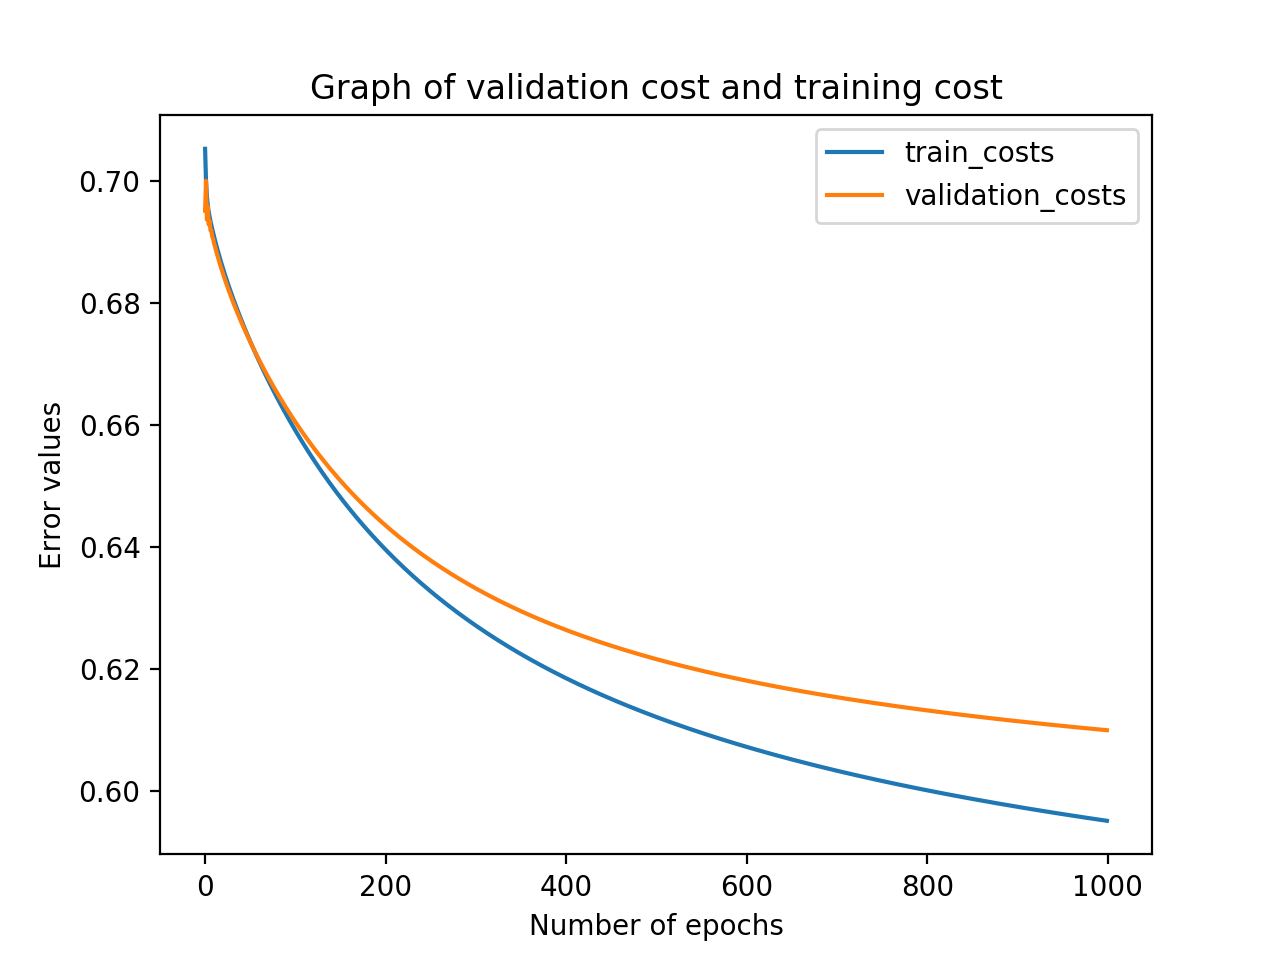

Accuracy of test set is:  0.7


In [5]:
lrObj = LRClass()
lrObj.train(X, Y, epochs=1000)

#(viii) After successfully training, apply the learned model on the test dataset
testX, testY = getBinaryfer13Data('fer3and4test.csv')
print("Accuracy of test set is: ", lrObj.score(testX, testY))

# PART 2 - Neural Network (1-layer)

In [7]:
#Implement a neural network class to read in vectorized 48 x 48 images;
#  so that the dimension of the input is 2304.
#  The class includes function train (weight learning), forward (forward activations), 
#  predict (using current weight to make predictions) and score (or accuracy based on targets and predictions)
class NNClass(object):
    def __init__(self):
        self.w1 = None
        self.w2 = None
        self.b1 = 0
        self.b2 = 0
    
    def train(self, X, Y, step_size=10e-7, epochs=10000, regularize=False, lamb=0.1, activation='sigmoid'):
        # Validation data set extracted from the training data
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]   
        K = len(set(Y))    #number of categories
        
        # Convert outputs of the NN to an indicator matrix
        Ytrain_ind = y2indicator(Y, K)
        Yvalid_ind = y2indicator(Yvalid, K)
        M, D = X.shape

        #(i) Randomly initialize all the hidden weights W's and biases b's 
        #ADD CODE HERE...
        # number of nodes in hidden layer = 100
        self.w1, self.b1 = init_weight_and_bias_NN(D, 100)
        self.w2, self.b2 = init_weight_and_bias_NN(100, K)
        
        #(ii) For the given number of epochs set, implement backpropagation to learn the
        #       weights and append computed costs in the 2 cost arrays
        train_costs = []
        valid_costs = []
        best_validation_error = 1
        for i in range(epochs):
            #(iii) Call forward propagation twice; once to calculate P(Ytrain|X) 
            #       and Ztrain (activations at hidden layer); second to calculate
            #       P(Yvalid|Xvalid) and Zvalid
            #ADD CODE HERE...
            py_train, z_train = self.forward(X)
            py_valid, z_valid = self.forward(Xvalid)

            #(iv) Now we do a first round of back propagation by first performing 
            #       gradient descent using equations (3) and (4) from the HW text
            #ADD CODE HERE...
            if regularize:
                self.w2 -= step_size * (np.dot(z_train.T, (py_train - Ytrain_ind)) + (lamb/(2*M))*(np.linalg.norm(self.w2, 1) + np.linalg.norm(self.w2)))
            else:
                self.w2 -= step_size * np.dot(z_train.T, (py_train - Ytrain_ind))
            self.b2 -= step_size * sum(py_train - Ytrain_ind)
            
            #(v) Then we propagate the errors we got from the previous layer W2 update W1 and b1
            #ADD CODE HERE...
            dj_by_dz = np.multiply(np.dot((py_train - Ytrain_ind), self.w2.T), (1-z_train*z_train))
            if regularize:
                if activation == 'sigmoid':
                    self.w1 -= step_size * (np.dot(X.T, dj_by_dz) + (lamb/(2*M))*(np.linalg.norm(self.w1, 1) + np.linalg.norm(self.w1)))
                elif activation == 'ReLU':
                    self.w1 -= step_size * (np.dot(X.T, np.multiply(np.dot((py_train - Ytrain_ind), self.w2.T), self.relu_prime(z_train))))
            else:
                self.w1 -= step_size * np.dot(X.T, dj_by_dz)
            self.b1 -= step_size * sum(dj_by_dz)
  
            #(vi) Compute the training and validation errors using cross_entropy cost
            #       function; once on the training predictions and once on validation predictions
            #       append errors to appropriate error array 
            #ADD CODE HERE...
            pY, z_train = self.forward(X)
            pY_valid, z_valid = self.forward(Xvalid)
            train_costs.append(self.cross_entropy(Ytrain_ind, pY))
            valid_costs.append(self.cross_entropy(Yvalid_ind, pY_valid))
                
        #(vii) Print out the best validation error and training and validation classification rates
        #ADD CODE HERE...
        best_validation_error = min(valid_costs)
        train_rate = self.classification_rate(Y, pY)
        valid_rate = self.classification_rate(Yvalid, pY_valid)
        print('Best validation error:', best_validation_error)
        print('training classification rate =', train_rate)
        print('validation classification rate =', valid_rate)

        #(viii) Display the training and validation cost graphs 
        #ADD CODE HERE...
        %matplotlib notebook
        plt.plot(list(range(epochs)), train_costs, label="train_costs")
        plt.plot(list(range(epochs)), valid_costs, label='validation_costs')
        plt.title('Graph of validation cost and training cost')
        plt.xlabel('Number of epochs')
        plt.ylabel('Error values')
        plt.legend(loc='upper right')
        plt.show()
#         plt.savefig('neural_network_loss.jpg')
    
    def relu_prime(self, Z):
        for i in range(len(Z)):
            for j in range(Z[i]):
                if Z[i,j] >= 0:
                    Z[i,j] = 1
                else:
                    Z[i,j] = 0
        return Z

    # Implement the forward algorithm
    def forward(self, X, activation=sigmoid):
        #ADD CODE HERE...
        h = np.dot(X, self.w1) + self.b1
        if activation == 'ReLU':
            z = ReLU(h)
        else:
            z = sigmoid(h)
        y = softmax(np.dot(z, self.w2) + self.b2)
        return y, z

    # Implement the prediction algorithm
    def predict(self, P_Y_given_X):
        #ADD CODE HERE...
        return np.argmax(P_Y_given_X, axis=1)
        
    # Implement a method to compute accuracy or classification rate
    def classification_rate(self, Y, P):
        #ADD CODE HERE...
        return round(np.sum(Y == self.predict(P))/len(Y), 2)
        
    def cross_entropy(self, T, pY):
        #ADD CODE HERE...
        return sigmoid_cost(T, pY)

Best validation error: 0.6658789770323892
training classification rate = 0.62
validation classification rate = 0.63


<IPython.core.display.Javascript object>


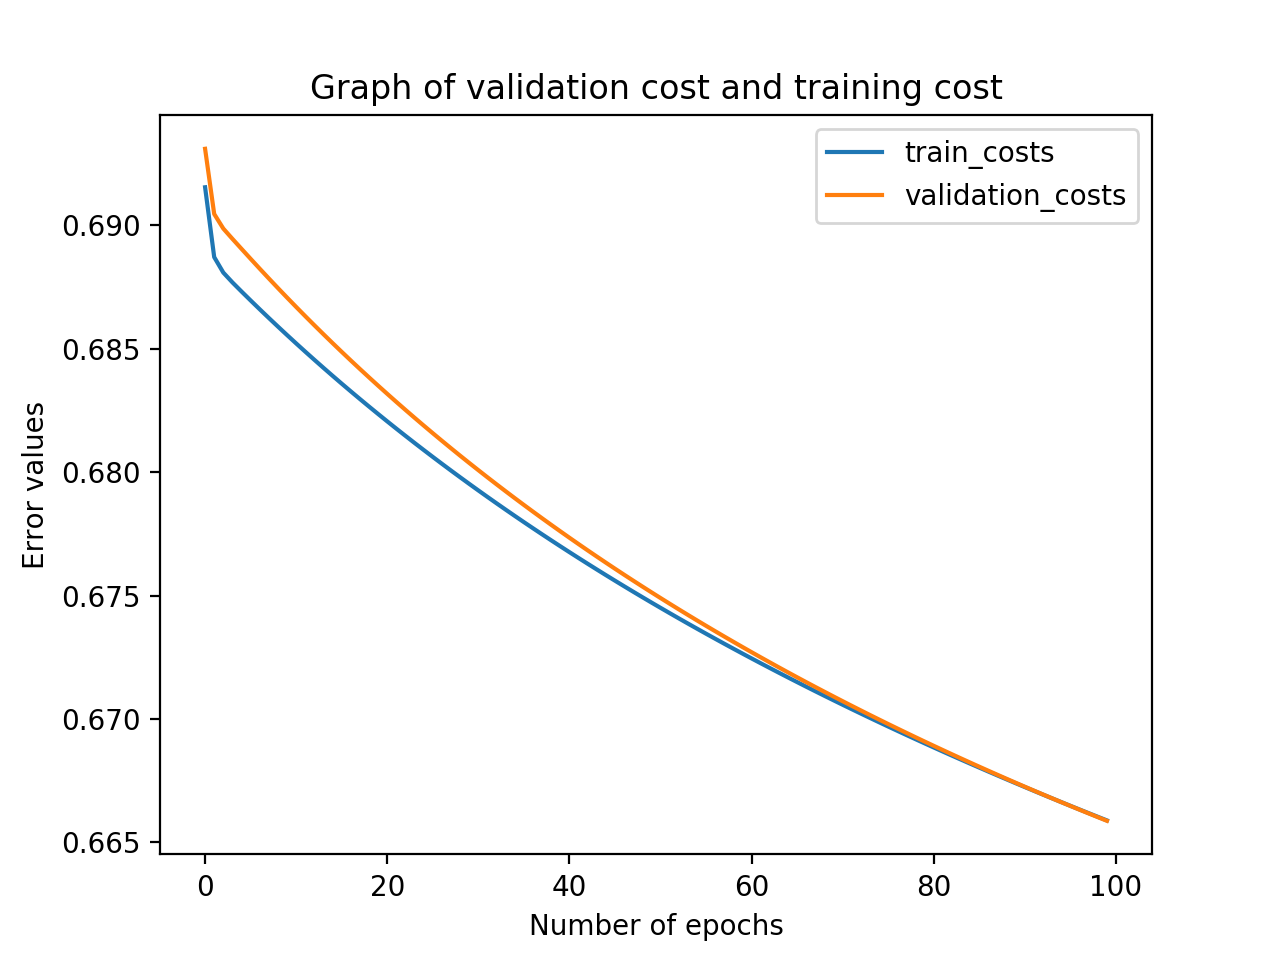

Accuracy of test set is : 0.63


In [8]:
#Call your neural network class and train your object
X, Y = getBinaryfer13Data('fer3and4train.csv')
nnObj = NNClass()
nnObj.train(X, Y, epochs=100)

#(ix) After successfully training, apply the learned model on the test dataset
testX, testY = getBinaryfer13Data('fer3and4test.csv')
output, hidden = nnObj.forward(testX)

accuracy = nnObj.classification_rate(testY, output)
print("Accuracy of test set is :", accuracy)

Best validation error: 0.6699864942224192
training classification rate = 0.62
validation classification rate = 0.59


<IPython.core.display.Javascript object>


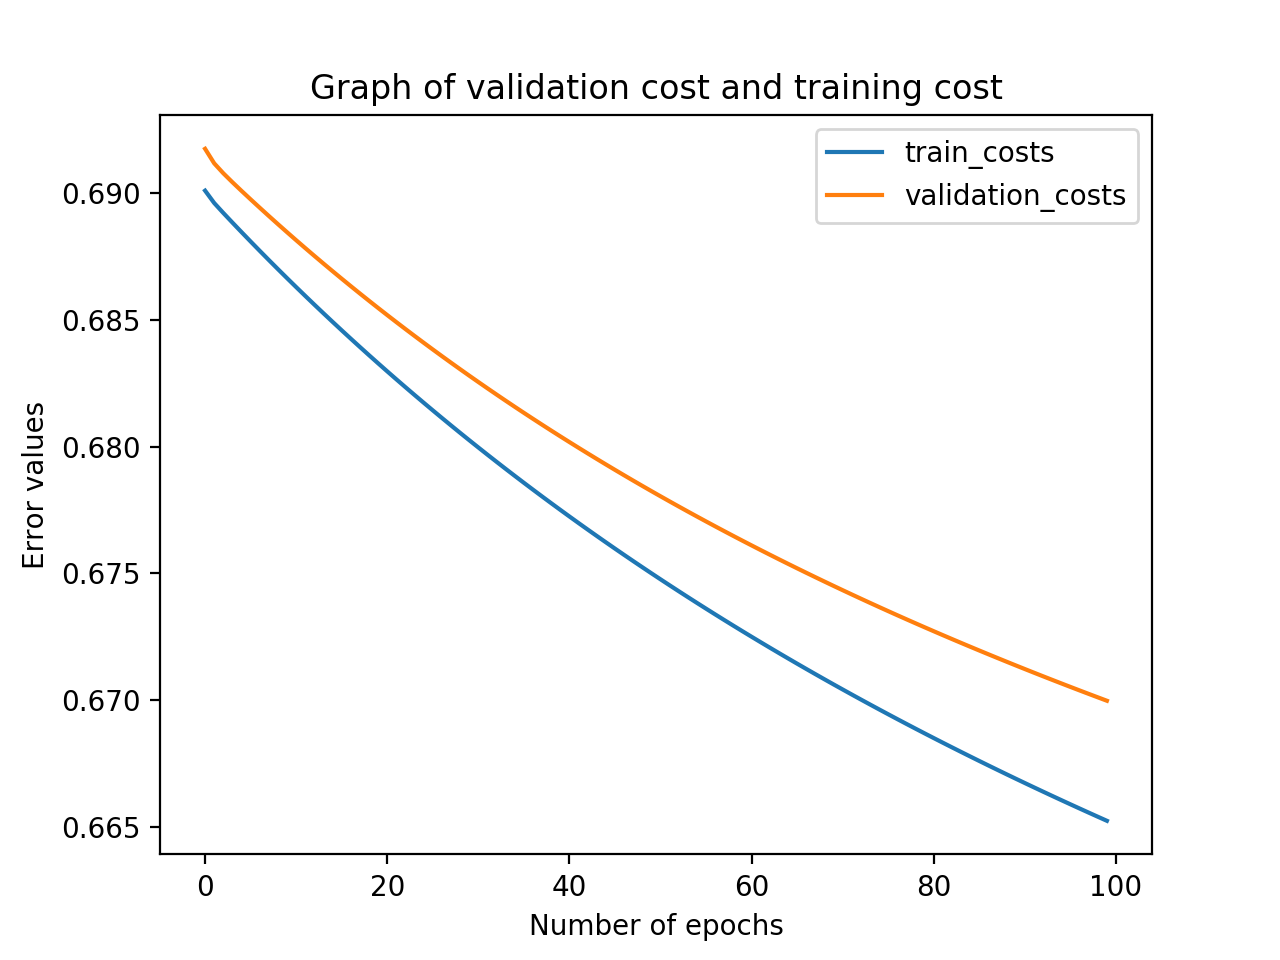

Accuracy of test set is : 0.65


In [15]:
nnObj = NNClass()
nnObj.train(X, Y, epochs=100, regularize=True, lamb=0.6)

output, hidden = nnObj.forward(testX)
accuracy = nnObj.classification_rate(testY, output)
print("Accuracy of test set is :", accuracy)

# PART 3 - SVM Classification

**NOTE**: Additional module imported for calculating accuracy score as follows <br />
`from sklearn.metrics import accuracy_score`

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


#Train the SVM
X, Y = getBinaryfer13Data('fer3and4train.csv')

#ADD CODE HERE...
linear_classifier = SVC(kernel='linear')
rbf_classifier = SVC(kernel='rbf')
poly_classifier = []
degrees = [4,6,8]
for deg in degrees:
    poly_classifier.append(SVC(kernel='poly', degree=deg))
    poly_classifier[-1].fit(X,Y)
linear_classifier.fit(X,Y)
rbf_classifier.fit(X,Y)

#Test the SVM
#ADD CODE HERE...

linear_output = linear_classifier.predict(testX)
rbf_output = rbf_classifier.predict(testX)
poly_output = []
for model in poly_classifier:
    poly_output.append(model.predict(testX))

In [19]:
from sklearn.metrics import accuracy_score

print('accuracy of SVM with linear kernel:', accuracy_score(testY, linear_output))
print('accuracy of SVM with rbf kernel:', accuracy_score(testY, rbf_output))
print('accuracy of SVM with polynomial kernel of degree 4:', accuracy_score(testY, poly_output[0]))
print('accuracy of SVM with polynomial kernel of degree 6:', accuracy_score(testY, poly_output[1]))
print('accuracy of SVM with polynomial kernel of degree 8:', accuracy_score(testY, poly_output[2]))

#Report overall the accuracy from the results of the different SVM kernels
print('results for linear kernel:')
print(confusion_matrix(testY, linear_output))
print(classification_report(testY, linear_output))
print()

print('results for rbf kernel:')
print(confusion_matrix(testY, rbf_output))
print(classification_report(testY, rbf_output))
print()

print('results for polynomial kernel with degree 4:')
print(confusion_matrix(testY, poly_output[0]))
print(classification_report(testY, poly_output[0]))
print()

print('results for polynomial kernel with degree 6:')
print(confusion_matrix(testY, poly_output[1]))
print(classification_report(testY, poly_output[1]))
print()

print('results for polynomial kernel with degree 8:')
print(confusion_matrix(testY, poly_output[2]))
print(classification_report(testY, poly_output[2]))
print()

accuracy of SVM with linear kernel: 0.674
accuracy of SVM with rbf kernel: 0.7033333333333334
accuracy of SVM with polynomial kernel of degree 4: 0.5296666666666666
accuracy of SVM with polynomial kernel of degree 6: 0.454
accuracy of SVM with polynomial kernel of degree 8: 0.42866666666666664
results for linear kernel:
[[ 817  423]
 [ 555 1205]]
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1240
           1       0.74      0.68      0.71      1760

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.68      0.67      0.68      3000


results for rbf kernel:
[[ 891  349]
 [ 541 1219]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1240
           1       0.78      0.69      0.73      1760

    accuracy                           0.70      3000
   macro avg       0.70      0.71      0.70      3000


# BONUS

Best validation error: 0.6655023140377668
training classification rate = 0.62
validation classification rate = 0.6


<IPython.core.display.Javascript object>


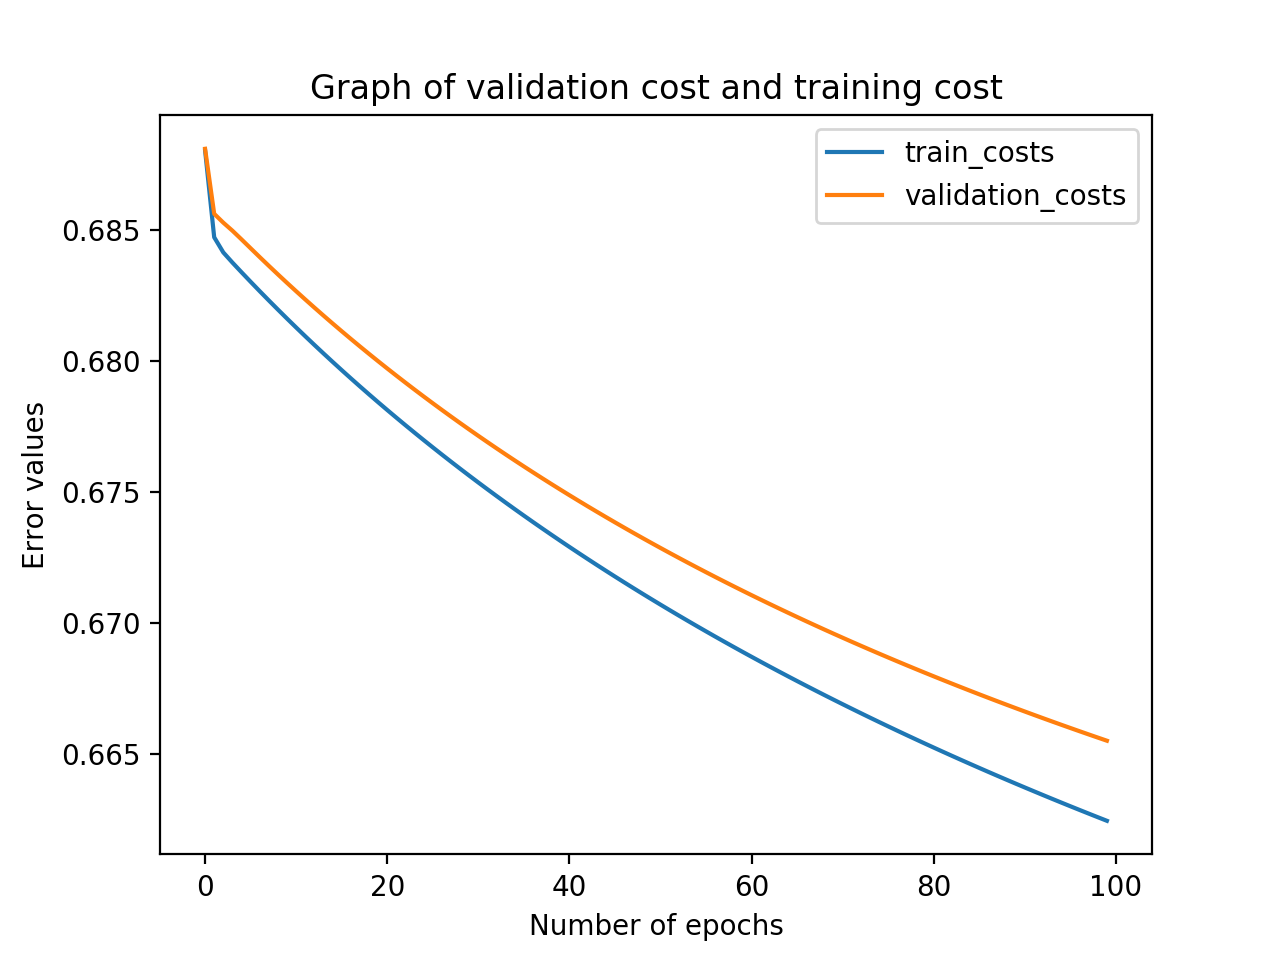

Accuracy of test set is : 0.64


In [20]:
nnObj = NNClass()
nnObj.train(X, Y, epochs=100)
output, hidden = nnObj.forward(testX)

accuracy = nnObj.classification_rate(testY, output)
print("Accuracy of test set is :", accuracy)

Best validation error: 0.6751923131019044
training classification rate = 0.61
validation classification rate = 0.59


<IPython.core.display.Javascript object>


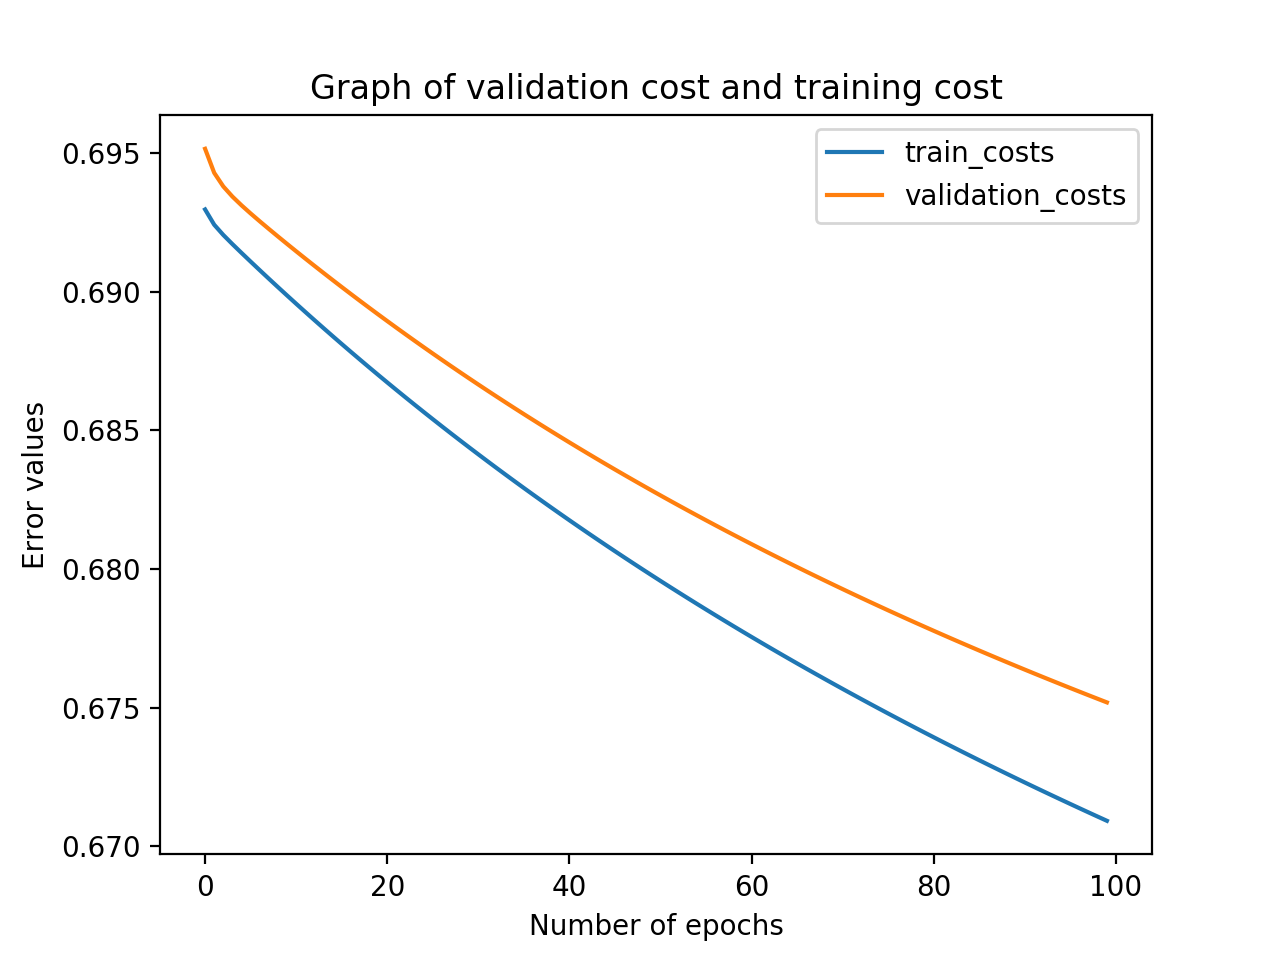

Accuracy of test set is : 0.64


In [21]:
nnObj = NNClass()
nnObj.train(X, Y, epochs=100, regularize=True, lamb=0.4)
output, hidden = nnObj.forward(testX)

accuracy = nnObj.classification_rate(testY, output)
print("Accuracy of test set is :", accuracy)